# Multi-armed bandits

In the [multi-armed bandit (MAB)](https://en.wikipedia.org/wiki/Multi-armed_bandit) problem we try to maximise our gain over time by "gambling on slot-machines (bandits)" that have different, unknown expected outcomes.

The MAB is the simplest setup to study the **exploration-exploitation tradeoff**

MAB setups can be used over [A/B-testing](https://en.wikipedia.org/wiki/A/B_testing) methodology -- view each product or webpage as a different slot machine.

The advantage in this case will be that instead of inefficiently sending people to the wrong page for testing, the MAB experiment will efficiently send users to the most profitable page **as data is gathered**.

Credit for some code in this lecture goes to https://peterroelants.github.io/ which has great educative notebooks.

In [26]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Define the multi-armed bandits
N_BANDITS = 3  # Number of bandits
# True probability of winning for each bandit
P_BANDITS = [0.45, 0.55, 0.60]
# epsilon parameter
EPS = 0.1
# Number of random runs
N_RUNS = 1000
# Iterations to plot
plot_steps = [1, 2, 5, 10, 25, 50, 100, 200, 500, 1000]


def plot(priors, step, ax):
    """Plot the priors for the current step."""
    plot_x = np.linspace(0.001, .999, 100)
    for prior in priors:
        y = prior.pdf(plot_x)
        p = ax.plot(plot_x, y)
        ax.fill_between(plot_x, y, 0, alpha=0.2)
    ax.set_xlim([0, 1])
    ax.set_ylim(bottom=0)
    ax.set_title(f'Priors at step {step:d}')

# Epsilon-Greedy method

The simplest solution to the MAB problem is the **epsilon-greedy algorithm:**

1. Initialize all arms to have equal expected values
2. Choose a random number in $[0,1]$

    2.a Choose a random arm with probability $\epsilon$

    2.b Choose the current best arm with probability $(1-\epsilon)$ (break ties randomly)
3. Observe outcome and update expected values

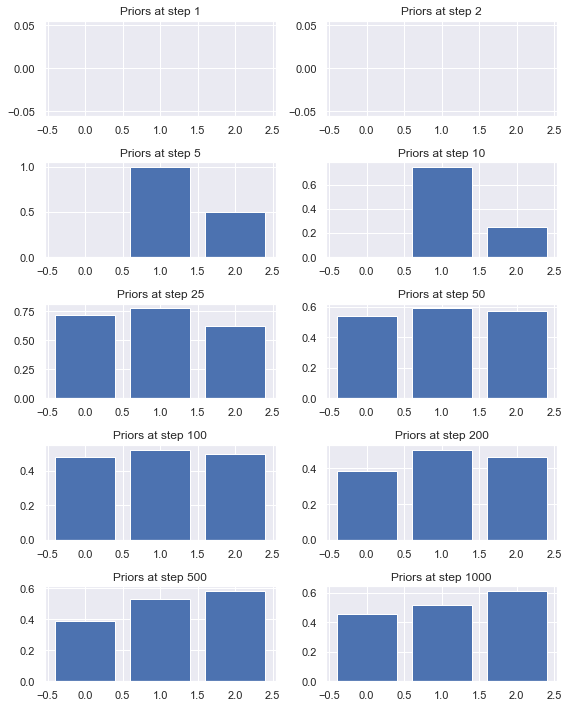

In [27]:
# Simulate multi-armed bandit process and update posteriors

# Setup plot
fig, axs = plt.subplots(5, 2, figsize=(8, 10))
axs = axs.flat

# Number of times we tried each arm
trials = np.zeros(N_BANDITS)
# Number of wins for each arm
wins = np.zeros(N_BANDITS)

# Run the trail for `n` steps
for step in range(1, N_RUNS+1):
    emp_prob = np.divide(
            wins, trials, 
            where=(trials != 0), 
            out=np.zeros(N_BANDITS)
        )
    # plot prior
    if step in plot_steps:
        ax = next(axs)
        ax.bar(x=np.arange(N_BANDITS), height=emp_prob)
        ax.set_title(f'Priors at step {step:d}')
    coin = np.random.rand() < EPS
    if coin:
        emp_prob = np.divide(
            wins, trials, 
            where=(trials != 0), 
            out=np.zeros(N_BANDITS)
        )
        # choose a bandit
        chosen_bandit = np.argmax(emp_prob)
    else:
        chosen_bandit = np.random.randint(N_BANDITS)
    # Update trials and wins (defines the posterior)
    trials[chosen_bandit] += 1
    # Pull the bandit
    if np.random.rand() < P_BANDITS[chosen_bandit]:
        wins[chosen_bandit] += 1

plt.tight_layout()
plt.show()

# Bayesian Modelling

Based on oberving a single outcome $x$ we can model this as the distribution $P(\theta \mid x)$ to model the unkown probability with a parameter $\theta$ using [Bayes rule](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$
P(\theta \mid x) = \frac{P(x \mid \theta)P(\theta)}{P(x)}
$$

$P(\theta \mid x)$ is called the posterior distribution of $\theta$ after observing $x$. We will be able to compute this via the likelihood $P(x \mid \theta)$ and prior $P(\theta)$. In this case the likelihood function $P(x \mid \theta)$ follows the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution). 


### Beta prior

A good choice for the prior $P(\theta)$ would be the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) since it is a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior#Discrete_distributions) to the Bernoulli distribution. 
This means that if the likelihood function $P(x \mid \theta)$ is Bernoulli distributed and the prior distribution  $P(\theta)$ is Beta distributed then the posterior $P(\theta \mid x)$ will also Beta distributed. More specifically if the prior is $Beta(\alpha, \beta)$ then after observing a win $x=1$ the posterior would become $Beta(\alpha+1, \beta)$, or after observing a loss $x=0$ the posterior would become $Beta(\alpha, \beta+1)$ [[1](#Further-readings)]. 

This means that after every observation we can use the posterior as the prior for the next time we pull the bandit's arm.

# Thompson Sampling

We will use [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling) to overcome this problem. In Thompson sampling we will for each bandit sample the probability $\theta$ from the prior and pull the bandit with the highest sampled probability. And repeat this step until finished.

We will start with the prior $Beta(\alpha=1, \beta=1)$, which corresponds to a [uniform](https://en.wikipedia.org/wiki/Uniform_distribution_%28continuous%29) prior between 0 and 1. The run is simulated for 1000 steps and the results at certain steps are plotted below.

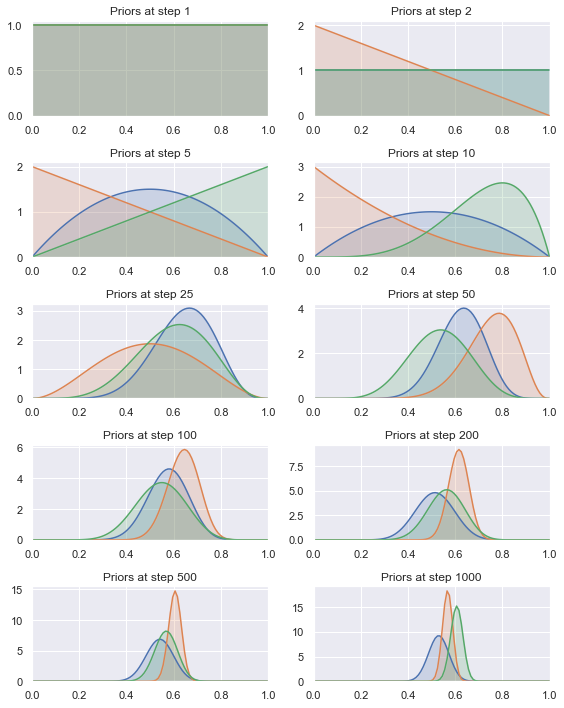

In [29]:
# Simulate multi-armed bandit process and update posteriors

# Setup plot
fig, axs = plt.subplots(5, 2, figsize=(8, 10))
axs = axs.flat

# The number of trials and wins will represent the prior for each
#  bandit with the help of the Beta distribution.
trials = [0, 0, 0]  # Number of times we tried each bandit
wins = [0, 0, 0]  # Number of wins for each bandit

n = 1000
# Run the trail for `n` steps
for step in range(1, N_RUNS+1):
    # Define the prior based on current observations
    bandit_priors = [
        stats.beta(a=1+w, b=1+t-w) for t, w in zip(trials, wins)]
    # plot prior 
    if step in plot_steps:
        plot(bandit_priors, step, next(axs))
    # Sample a probability theta for each bandit
    theta_samples = [
        d.rvs(1) for d in bandit_priors
    ]
    # choose a bandit
    chosen_bandit = np.argmax(theta_samples)
    # Update trials and wins (defines the posterior)
    trials[chosen_bandit] += 1
    # Pull the bandit
    if np.random.rand() < P_BANDITS[chosen_bandit]:
        wins[chosen_bandit] += 1

plt.tight_layout()
plt.show()

## Further readings

1. [Understanding the beta distribution (using baseball statistics)](http://varianceexplained.org/statistics/beta_distribution_and_baseball/) - David Robinson
2. [Formulas for Bayesian A/B Testing](http://www.evanmiller.org/bayesian-ab-testing.html) - Evan Miller
3. http://ethen8181.github.io/machine-learning/bandits/multi_armed_bandits.html